# **Transfer learning**

[Transfer Learning]() is a powerful technique that allows sophisticated convolutional neural networks (CCNs) trained by Google, Microsoft, and others on high-performance computing (HPC) clusters equipped  with GPUs to be purposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between hot dogs and hamburgers. And you can do it on a laptop computer - no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. In this exercise, you will use Keras and Microsoft's [ResNet50V2]() pretrained CNN to build a network that distinguishes with a high degree of accuracy between images containing dogs and cats.

## **Create an image pipeline**

The first step is to use Keras's [ImageDataGenerator]() class to create a pipeline for loading images. We will create two images pipelines, one for training images and one for test images. Because images input to `ResNet50V2` must be preprocessed by Keras's `keras.applications.resnet50.preprocess_input` function, we will configure `ImageDataGenerator` to use that function. We will also disable image shuffling so we can recreate the labels that go with the images later on.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

batch_size = 5
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory='cats_and_dogs_filtered/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,   # Avoid shuffling so labels can be recreated
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory='cats_and_dogs_filtered/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Avoid shuffling so labels can be recreated
    seed=42
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In order to visualize the data, let's use Matplotlib to plot the first eight training images. The images look different than before because the `preprocess_input` function converts them from RGB format to BGR, but they are still recognizable as pets images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


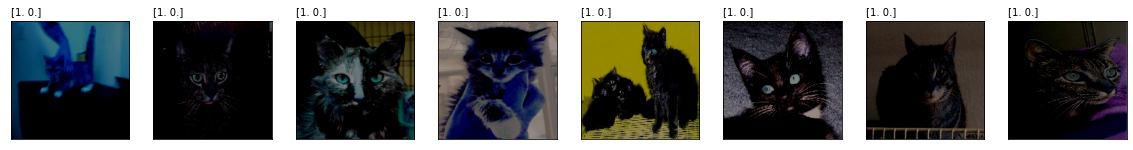

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = np.concatenate([train_generator[0][0], train_generator[1][0]]) # First 10 images
labels = np.concatenate([train_generator[0][1], train_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)

train_generator.reset()

Now let's do the same for the first eight test images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


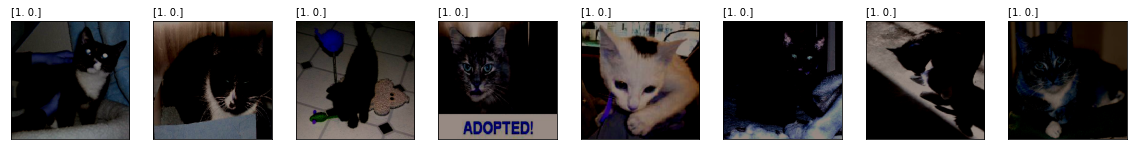

In [4]:
images = np.concatenate([test_generator[0][0], test_generator[1][0]]) # First 10 images
labels = np.concatenate([test_generator[0][1], test_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)

train_generator.reset()

## **Use ResNet50V2 to extract features from images**

Rather than create a CNN of our own, we will load ResNet50V2 minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet]() dataset. We will then run our training and test images through it to extract features from them. The code that generates the labels assumes that the images are served up in the same order every time they're fetched, which is why we set `shuffle` to `False` when we initialized `ImageDataGenerator`.

In [5]:
from keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X_train = base_model.predict(train_generator)
X_test = base_model.predict(test_generator)

train_generator.reset()
test_generator.reset()

94674944/94668760 [==============================] - 45s 0us/step

Now let's generate a set of labels to go with the features extracted from the training and test images.

In [6]:
y_train = []
iterations = train_generator.samples // batch_size

for i in range(iterations):
    y_train.extend(np.array(train_generator[i][1]))

y_train = np.array(y_train)

y_test = []
iterations = test_generator.samples // batch_size

for i in range(iterations):
    y_test.extend(np.array(test_generator[i][1]))

y_test = np.array(y_test)

train_generator.reset()
test_generator.reset()

## **Train a network with the output from ResNet50V2**

Now that we've used `ResNet50V2` to process dogs and cats, it's a simple matter to replace that network's classification layers with classification layers of our own and train them  with the output. Oncec more, we'll use a modest amount of dropout in hopes that the network will generalize better.

In [7]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 1.1214 - accuracy: 0.9425 - val_loss: 0.1218 - val_accuracy: 0.9710

How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

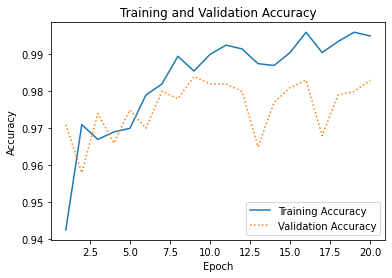

In [9]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot();

## **Make a preddiction**

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take a dog image and see how the network classifies it. The first step is to load the image.

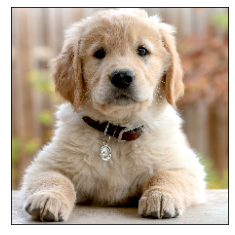

In [12]:
from keras.preprocessing import image

x = image.load_img(path='cats_and_dogs_filtered/samples/dog.jpeg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x);

Next. we preprocess the image and run it through `ResNet50V2`'s feature-extraction layers, and then run the output through our newly trained classification layers.

In [13]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255   # Divide by 255 to rescale the image the same way ImageDataGenerator did

# Make a prediction
y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

[0. 1.]


The model predicts with a high degree of certainty that the image contains an examples of class 1. But what is class 1? We can get a dictionary of class names and 1-based class indices from `ImageDataGenerator`'s `class_indices` attribute, and then use it to correlate probabilities to class labels such as "dog" and "cat". Here's how the model scored the image for all two classes.

In [14]:
def show_labeled_probs(prediction, indices):
    for i in range(prediction.size):
        label = list(indices.keys())[list(indices.values()).index(i)]
        print(f'{label}: {prediction[i]*100}%')

show_labeled_probs(predictions[0], train_generator.class_indices)

cats: 0.0%
dogs: 100.0%


Now let's try it with a sushi image. Start by loading the image.

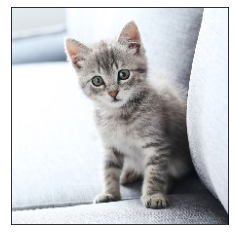

In [16]:
x = image.load_img(path='cats_and_dogs_filtered/samples/cat.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x);

Preprocess the image and make a prediction.

In [17]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255   # Divide by 255 to rescale the image the same way ImageDataGenerator did

# Make a prediction
y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

show_labeled_probs(predictions[0], train_generator.class_indices)

[1. 0.]
cats: 100.0%
dogs: 0.0%


ResNet50V2 wasn't trained to recognize cats in images, but our network was.